# <center> CSML1020 - Project </center>
# <center> Pneumonia Detection - Xray Classification </center>

# Table of Contents

* [1. Data Exploration](#1)
* [2. Data Preparation](#2)

# 1. Data Exploration<a class="anchor" id="1"></a>

The data exploration presented in this notebook is based on the approach present in the following towards data science article: https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2 

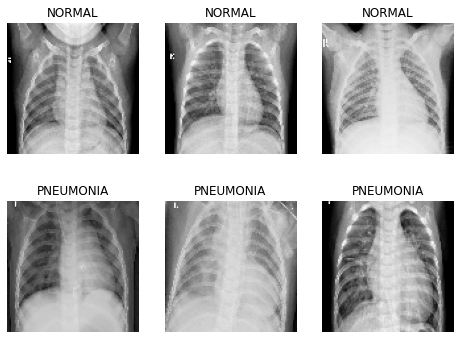

The total number of normal xrays:  1341
The total number of pneumonia xrays:  3875


In [1]:
# Display 3 randomly selected normal and pneumonia xray images and display
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline

train_normal = 'C:\\Users\\Joshua\\Desktop\\Graduate Certificate - Machine Learning\\CSML1020\\Project_pneumonia\\train\\NORMAL' 
train_pneumonia = 'C:\\Users\\Joshua\\Desktop\\Graduate Certificate - Machine Learning\\CSML1020\\Project_pneumonia\\train\\PNEUMONIA' 

# get the list of jpegs from sub image class folders
normal_imgs = [fn for fn in os.listdir(train_normal) if fn.endswith('.jpeg')]
pneumo_imgs = [fn for fn in os.listdir(train_pneumonia) if fn.endswith('.jpeg')]

# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = train_normal + '\\' + select_norm[i]
        label = 'NORMAL'
    else:
        fp = train_pneumonia + '\\' + select_pneu[i-3]
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
print("The total number of normal xrays: ",len(normal_imgs))
print("The total number of pneumonia xrays: ", len(pneumo_imgs))

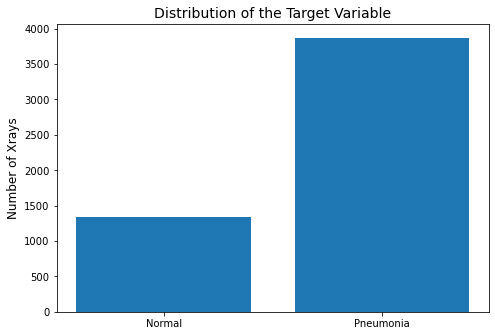

In [2]:
# Visualize the distribution of the target variable
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Normal','Pneumonia']
images = [len(normal_imgs),len(pneumo_imgs)]
ax.bar(labels,images)
plt.title('Distribution of the Target Variable',fontsize=14)
plt.ylabel('Number of Xrays', fontsize=12)
plt.show()

* Observing the distribution of the two classes, it can be seen that our dataset is imbalanced. This will be addressed further  on in the code using image augmentation.

In [3]:
import PIL

# Determining the size of an image:
def imgSize(path,list_of_filename):
    width_list  = []
    height_list  = []
    # iterating through each file
    for fn in list_of_filename:
        fp = path + '\\' + fn
        # Open the current image
        current_image = PIL.Image.open(fp)
        # Retireve the width and height of the image
        width, height = current_image.size
        # Save values in an array
        width_list.append(width)
        height_list.append(height)
    return width_list, height_list

# Determine the minimum image size 
def minImgSize(width,height):
    resolution = []
    for i in range(len(width)):
        res = width[i]*height[i]
        resolution.append(res)
    min_index = resolution.index(min(resolution))
    return width[min_index],height[min_index],resolution

In [4]:
# Determine the smallest image size in the dataset

# Normal Xrays:
w,h = imgSize(train_normal, normal_imgs)
img_width,img_height,res_n = minImgSize(w,h)
print("Normal image width: ",img_width)
print("Normal image height: ",img_height)

# Pneumonia Xrays:
w,h = imgSize(train_pneumonia, pneumo_imgs)
img_width,img_height,res_p = minImgSize(w,h)
print("Pneumonia image width: ",img_width)
print("Pneumonia image height: ",img_height)

Normal image width:  912
Normal image height:  672
Pneumonia image width:  384
Pneumonia image height:  127


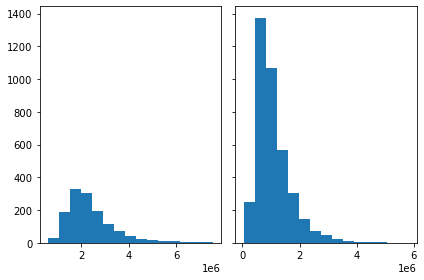

In [11]:
import pandas as pd
res = res_n + res_p
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins = 15
# We can set the number of bins with the `bins` kwarg
axs[0].hist(res_n, bins=n_bins)
axs[1].hist(res_p, bins=n_bins)

# Save the results to a csv format
arr = np.array(res)
arr = pd.DataFrame(arr)
arr.to_csv('resolution.csv')

(array([ 236., 1324., 1126.,  758.,  579.,  427.,  273.,  183.,  111.,
          68.,   34.,   34.,   20.,   12.,    6.,   12.,    6.,    2.,
           3.,    2.]),
 array([  48768.,  422931.,  797094., 1171257., 1545420., 1919583.,
        2293746., 2667909., 3042072., 3416235., 3790398., 4164561.,
        4538724., 4912887., 5287050., 5661213., 6035376., 6409539.,
        6783702., 7157865., 7532028.]),
 <BarContainer object of 20 artists>)

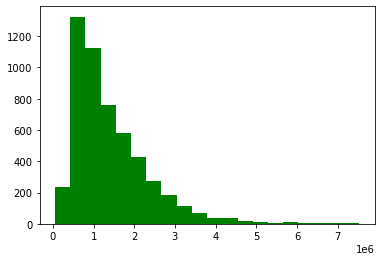

In [13]:
plt.hist(res, 20, facecolor='green',)

* For modelling, it might be beneficial to convert all the images to the following size: 384x127

In [5]:
# making n X m matrix
def img2np(path,list_of_filename, size = (128, 128)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + '\\' + fn
        current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [6]:
%%time

# Covnert the images in the Normal folder to array format of size 64x64 for exploration purposes
normal_img_array = img2np(train_normal,normal_imgs)

Wall time: 44.2 s


In [7]:
# Convert the image array into a dataframe
import pandas as pd
df_normal_imgs = pd.DataFrame(normal_img_array)
df_normal_imgs['Image_Id'] = normal_imgs
df_normal_imgs['has_Pneumonia?'] = 0
df_normal_imgs.head(2)

,0,1,2,3,4,5,6,7,8,9,...,16376,16377,16378,16379,16380,16381,16382,16383,Image_Id,has_Pneumonia?
0,22.0,20.0,16.0,50.0,60.0,69.0,75.0,83.0,90.0,92.0,...,89.0,87.0,91.0,94.0,93.0,94.0,95.0,96.0,IM-0115-0001.jpeg,0
1,20.0,26.0,30.0,35.0,45.0,45.0,44.0,54.0,87.0,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IM-0117-0001.jpeg,0


In [8]:
%%time

# Covnert the images in the Normal folder to array format of size 64x64 for exploration purposes
pneumonia_img_array = img2np(train_pneumonia,pneumo_imgs)

Wall time: 3min 4s


In [9]:
# Convert the image array into a dataframe
import pandas as pd
df_pneumonia_imgs = pd.DataFrame(pneumonia_img_array)
df_pneumonia_imgs['Image_Id'] = pneumo_imgs
df_pneumonia_imgs['has_Pneumonia?'] = 1
df_pneumonia_imgs.head(2)

,0,1,2,3,4,5,6,7,8,9,...,16376,16377,16378,16379,16380,16381,16382,16383,Image_Id,has_Pneumonia?
0,19.0,27.0,30.0,39.0,42.0,52.0,52.0,58.0,64.0,64.0,...,9.0,12.0,12.0,14.0,15.0,15.0,15.0,15.0,person1000_bacteria_2931.jpeg,1
1,65.0,73.0,81.0,93.0,100.0,96.0,107.0,99.0,106.0,106.0,...,45.0,29.0,17.0,9.0,0.0,0.0,0.0,0.0,person1000_virus_1681.jpeg,1


In [10]:
# Combine the normal and pneumonia dataframes
frames = [df_normal_imgs,df_pneumonia_imgs]
df_xray_imgs_array = pd.concat(frames)

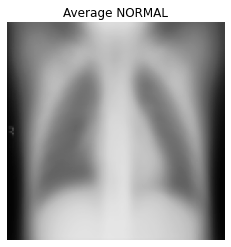

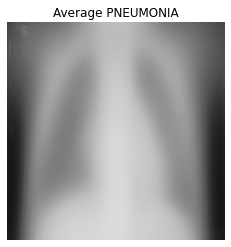

In [11]:
%matplotlib inline
# Average Image
def find_mean_img(full_mat, title, size = (128, 128)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_img_array, 'NORMAL')
pneu_mean = find_mean_img(pneumonia_img_array, 'PNEUMONIA')

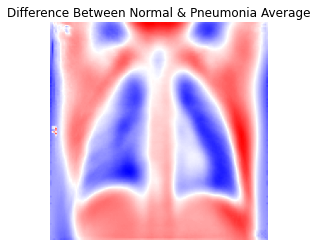

In [12]:
# Display the difference between the average normal Xray and pneumonia Xray

contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()

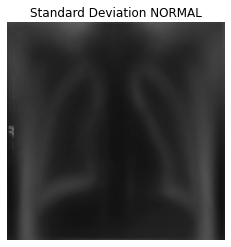

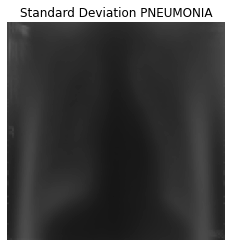

In [13]:
# Display the standard deviation of each image class
%matplotlib inline

# standard deviation of an Image
def find_std_img(full_mat, title, size = (128,128)):
    # calculate the average
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

norm_std = find_std_img(normal_img_array, 'NORMAL')
pneu_std = find_std_img(pneumonia_img_array, 'PNEUMONIA')

Number of PC:  28


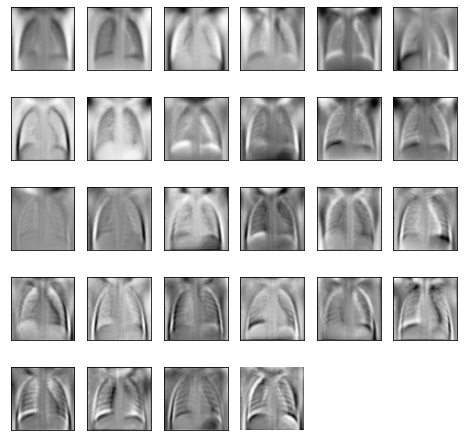

Number of PC:  14


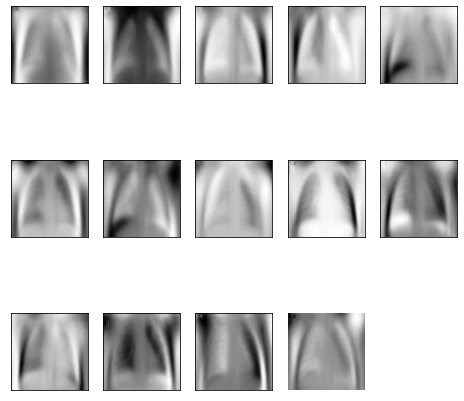

In [15]:
# Eigen Images. Explore the images using dimension reduction PCA
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (128,128)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca,size = (128, 128)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(normal_img_array, 'NORMAL'))
plot_pca(eigenimages(pneumonia_img_array, 'PNEUMONIA'))

In [47]:
# Save the results to a csv format
df_xray_imgs_array.to_csv('train_img_array.csv')
#df_final.to_csv('train_images_array.csv')

# 2. Data Preparation<a class="anchor" id="2"></a>

* The approach used for image augmentation is based on the methods described in the following articles:
 * https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [88]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

def horizontal_img_shift(source_path,image_list,save_path):
    for image in image_list:
        # Retrieve the path to the image file
        fp = source_path + '\\' + image
        # Load the image
        img = load_img(fp)
        # Conver the image to array format
        data = img_to_array(img)
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(width_shift_range=[-150,150])
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image_array = batch[0].astype('uint8')
        # plot raw pixel data
        #pyplot.imshow(image_array)
        # show the figure
        #pyplot.show()
        # Save the image
        save_name = save_path + '\\' + image.replace('.jpg','') + '-shift augmented.jpeg'
        plt.imsave(save_name, image_array, cmap='Greys') 

In [89]:
# Definition of a function for image augmentation through zooming
def zoom_img(source_path,image_list,save_path):
    for image in image_list:
        # Retrieve the path to the image file
        fp = source_path + '\\' + image
        # Load the image
        img = load_img(fp)
        # Conver the image to array format
        data = img_to_array(img)
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(zoom_range=[0.75,1.0])
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image_array = batch[0].astype('uint8')
        # plot raw pixel data
        #pyplot.imshow(image_array)
        # show the figure
        #pyplot.show()
        # Save the image
        save_name = save_path + '\\' + image.replace('.jpg','') + '-zoom augmented.jpeg'
        plt.imsave(save_name, image_array, cmap='Greys') 

In [90]:
# Definition of a function for image augmentation through brightness adjustments
def brightness_img(source_path,image_list,save_path):
    for image in image_list:
        # Retrieve the path to the image file
        fp = source_path + '\\' + image
        # Load the image
        img = load_img(fp)
        # Conver the image to array format
        data = img_to_array(img)
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image_array = batch[0].astype('uint8')
        # plot raw pixel data
        #pyplot.imshow(image_array)
        # show the figure
        #pyplot.show()
        # Save the image
        save_name = save_path + '\\' + image.replace('.jpg','') + '-brightness augmented.jpeg'
        plt.imsave(save_name, image_array, cmap='Greys') 

In [96]:
from random import sample 

def oversample_image_dataset(source_path,save_path,n_samples):
    # source_path: is the path to the directory containing the source images
    # save_path: is the path to the directory which will store the newly created images
    # n_images: the number of images the user wishes to create
    # n_samples: the number sample images the user wishes to use as the base for oversampling
    
    # get the list of images from the source_path
    image_list = [fn for fn in os.listdir(source_path) if fn.endswith('.jpeg')]
    
    # randomly selected n_samples from the image_list
    image_sampled_list = sample(image_list,n_samples)
    #print(image_sampled_list)
      
    horizontal_img_shift(source_path,image_sampled_list,save_path)
    zoom_img(source_path,image_sampled_list,save_path)
    brightness_img(source_path,image_sampled_list,save_path) 
    
    # Split the image list into 3 parts
    #three_split = np.array_split(image_sampled_list, 3)
    #run_image_augmentation(three_split,source_path,save_path)    

def run_image_augmentation(three_split,source_path,save_path):
    ctr = 1
    for array in three_split:
        img_list = list(array)
        if ctr == 1:
            horizontal_img_shift(source_path,img_list,save_path)
        if ctr == 2:
            zoom_img(source_path,img_list,save_path)
        if ctr == 3:
            brightness_img(source_path,img_list,save_path)
        ctr = ctr + 1    
                
                

In [97]:
%%time
# Identifying paths to data
source_path = 'C:\\Users\\Joshua\\Desktop\\Graduate Certificate - Machine Learning\\CSML1020\\Project_pneumonia\\train\\NORMAL'
save_path   = 'C:\\Users\\Joshua\\Desktop\\Graduate Certificate - Machine Learning\\CSML1020\\Project_pneumonia\\train_augmented' 


oversample_image_dataset(source_path,save_path,800)

Wall time: 17min 34s
